In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
titanic_data=pd.read_csv("data/train.csv")
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Select columns with numerical data types
numeric_columns = titanic_data.select_dtypes(include=[np.number])

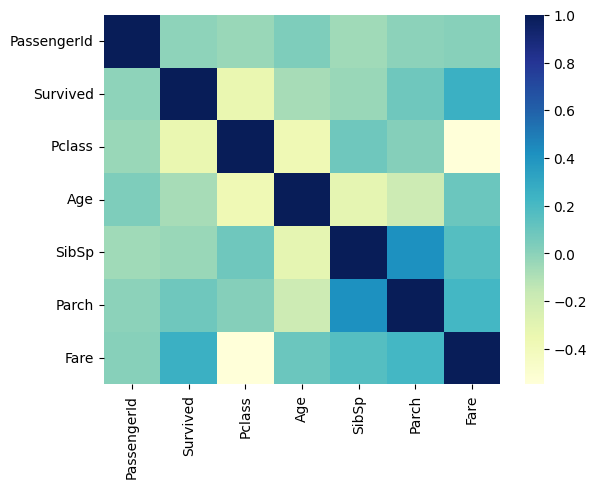

In [4]:
sns.heatmap(numeric_columns.corr(),cmap="YlGnBu")
plt.show()

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit
split=StratifiedShuffleSplit(n_splits=1,test_size=0.2)
for train_indices,test_indices in split.split(titanic_data,titanic_data[["Survived","Pclass","Sex"]]):
    strat_train_set=titanic_data.loc[train_indices]  
    strat_test_set=titanic_data.loc[test_indices]


In [8]:
strat_test_set

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
82,83,1,3,"McDermott, Miss. Brigdet Delia",female,NaN,0,0,330932,7.7875,NaN,Q
528,529,0,3,"Salonen, Mr. Johan Werner",male,39.0,0,0,3101296,7.9250,NaN,S
791,792,0,2,"Gaskell, Mr. Alfred",male,16.0,0,0,239865,26.0000,NaN,S
620,621,0,3,"Yasbeck, Mr. Antoni",male,27.0,1,0,2659,14.4542,NaN,C
605,606,0,3,"Lindell, Mr. Edvard Bengtsson",male,36.0,1,0,349910,15.5500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
377,378,0,1,"Widener, Mr. Harry Elkins",male,27.0,0,2,113503,211.5000,C82,C
51,52,0,3,"Nosworthy, Mr. Richard Cater",male,21.0,0,0,A/4. 39886,7.8000,NaN,S
256,257,1,1,"Thorne, Mrs. Gertrude Maybelle",female,NaN,0,0,PC 17585,79.2000,NaN,C
77,78,0,3,"Moutal, Mr. Rahamin Haim",male,NaN,0,0,374746,8.0500,NaN,S


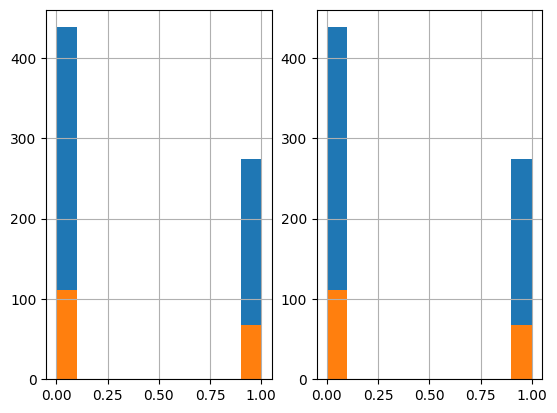

In [9]:
plt.subplot(1,2,1)
strat_train_set['Survived'].hist()
strat_test_set['Survived'].hist()

plt.subplot(1,2,2)
strat_train_set['Survived'].hist()
strat_test_set['Survived'].hist()

plt.show()

In [10]:
# check if we have missing values
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 14 to 42
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          576 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        162 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [21]:
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        imputer=SimpleImputer(strategy="mean")
        X['age']=imputer.fit_transform(X[['Age']])
        return X
        

In [22]:
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        encoder=OneHotEncoder()
        matrix=encoder.fit_transform(X[['Embarked']]).toarray()
        column_names=["C","S","Q","N"]
        for i in range(len(matrix.T)):
            X[column_names[i]]=matrix.T[i]
            
        matrix=encoder.fit_transform(X[['Sex']]).toarray()
        column_names=["male","female"]
        for i in range(len(matrix.T)):
            X[column_names[i]]=matrix.T[i]
        return X

In [23]:
class FeatureDropper(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return X.drop(["Embarked","Name","Ticket","Cabin","Sex","N"],axis=1,errors="ignore")

In [24]:
from sklearn.pipeline import Pipeline
pipeline=Pipeline([
    ("ageimputer",AgeImputer()),
    ("featureencoder",FeatureEncoder()),
    ("featuredropper",FeatureDropper()),
])

In [25]:
strat_train_set=pipeline.fit_transform(strat_train_set)

In [26]:
strat_train_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,age,C,S,Q,male,female
14,15,0,3,14.0,0,0,7.8542,14.000000,0.0,0.0,1.0,1.0,0.0
867,868,0,1,31.0,0,0,50.4958,31.000000,0.0,0.0,1.0,0.0,1.0
760,761,0,3,NaN,0,0,14.5000,29.473958,0.0,0.0,1.0,0.0,1.0
695,696,0,2,52.0,0,0,13.5000,52.000000,0.0,0.0,1.0,0.0,1.0
865,866,1,2,42.0,0,0,13.0000,42.000000,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,448,1,1,34.0,0,0,26.5500,34.000000,0.0,0.0,1.0,0.0,1.0
215,216,1,1,31.0,1,0,113.2750,31.000000,1.0,0.0,0.0,1.0,0.0
663,664,0,3,36.0,0,0,7.4958,36.000000,0.0,0.0,1.0,0.0,1.0
320,321,0,3,22.0,0,0,7.2500,22.000000,0.0,0.0,1.0,0.0,1.0


In [27]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 14 to 42
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Age          576 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   age          712 non-null    float64
 8   C            712 non-null    float64
 9   S            712 non-null    float64
 10  Q            712 non-null    float64
 11  male         712 non-null    float64
 12  female       712 non-null    float64
dtypes: float64(8), int64(5)
memory usage: 77.9 KB


In [28]:
from sklearn.preprocessing import StandardScaler

strat_train_set.fillna(method="ffill",inplace=True)
scaler=StandardScaler()

X=strat_train_set.drop(["Survived"],axis=1)
y=strat_train_set["Survived"]
X_data=scaler.fit_transform(X)
y_data=y.to_numpy()

C:\Users\legit\AppData\Local\Temp\ipykernel_15720\2749028009.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  strat_train_set.fillna(method="ffill",inplace=True)


In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clf=RandomForestClassifier()

param_grid=[
    {"n_estimators":[10,100,200,500],"max_depth":[None,5,10],"min_samples_split":[2,3,4]}
]

grid_search=GridSearchCV(clf,param_grid,cv=3,scoring="accuracy",return_train_score=True)
grid_search.fit(X_data,y_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [22]:
final_clf=grid_search.best_estimator_

In [23]:
final_clf

RandomForestClassifier(max_depth=5, min_samples_split=3, n_estimators=10)

In [24]:
strat_test_set=pipeline.fit_transform(strat_test_set)

In [25]:
strat_test_set

,pclass,survived,age,sibsp,parch,fare,C,S,Q,male,female
728,3,0,43.000000,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
1011,3,0,19.000000,1,0,16.1000,0.0,0.0,1.0,1.0,0.0
1027,3,0,29.897936,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
234,1,0,38.000000,0,0,0.0000,0.0,0.0,1.0,0.0,1.0
721,3,0,36.000000,0,0,7.4958,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
850,3,0,21.000000,0,0,7.8542,0.0,0.0,1.0,0.0,1.0
1283,3,0,29.897936,0,0,7.5500,0.0,0.0,1.0,0.0,1.0
57,1,1,36.000000,1,2,120.0000,0.0,0.0,1.0,1.0,0.0
118,1,0,29.897936,0,0,26.5500,0.0,0.0,1.0,0.0,1.0


In [26]:
X=strat_test_set.drop(["Survived"],axis=1)
y=strat_test_set["Survived"]
X_data_test=scaler.fit_transform(X)
y_data_test=y.to_numpy()

In [27]:
final_clf.score(X_data_test,y_data_test)

0.8091603053435115

In [28]:
final_data=pipeline.fit_transform(titanic_data)

In [29]:
final_data

,pclass,survived,age,sibsp,parch,fare,C,S,Q,male,female
0,1,1,29.000000,0,0,211.3375,0.0,0.0,1.0,1.0,0.0
1,1,1,0.916700,1,2,151.5500,0.0,0.0,1.0,0.0,1.0
2,1,0,2.000000,1,2,151.5500,0.0,0.0,1.0,1.0,0.0
3,1,0,30.000000,1,2,151.5500,0.0,0.0,1.0,0.0,1.0
4,1,0,25.000000,1,2,151.5500,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,14.500000,1,0,14.4542,1.0,0.0,0.0,1.0,0.0
1305,3,0,29.881135,1,0,14.4542,1.0,0.0,0.0,1.0,0.0
1306,3,0,26.500000,0,0,7.2250,1.0,0.0,0.0,0.0,1.0
1307,3,0,27.000000,0,0,7.2250,1.0,0.0,0.0,0.0,1.0


In [32]:
scaler=StandardScaler()
X_final=final_data.drop(["Survived"],axis=1)
y_final=final_data["Survived"]
x_final_data=scaler.fit_transform(X_final)
y_final_data=y_final.to_numpy()

In [33]:
prod_clf=RandomForestClassifier()

param_grid=[
    {"n_estimators":[10,100,200,500],"max_depth":[None,5,10],"min_samples_split":[2,3,4]}
]

grid_search=GridSearchCV(prod_clf,param_grid,cv=3,scoring="accuracy",return_train_score=True)
grid_search.fit(x_final_data,y_final_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [30]:
prod_final_clf=grid_search.best_estimator_

In [31]:
titanic_test_data=pd.read_csv("data/test.csv")

In [32]:
final_test_data=pipeline.fit_transform(titanic_test_data)

In [33]:
final_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Age          332 non-null    float64
 3   SibSp        418 non-null    int64  
 4   Parch        418 non-null    int64  
 5   Fare         417 non-null    float64
 6   age          418 non-null    float64
 7   C            418 non-null    float64
 8   S            418 non-null    float64
 9   Q            418 non-null    float64
 10  male         418 non-null    float64
 11  female       418 non-null    float64
dtypes: float64(8), int64(4)
memory usage: 39.3 KB


In [34]:
X_final_test=final_test_data.fillna(method="ffill")
scaler=StandardScaler()
X_final_test_data=scaler.fit_transform(X_final_test)

C:\Users\legit\AppData\Local\Temp\ipykernel_15720\2160250562.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_final_test=final_test_data.fillna(method="ffill")


In [36]:
predictions=prod_final_clf.predict(X_final_test_data)

In [37]:
predictions

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [39]:
final_df=pd.DataFrame(titanic_test_data["PassengerId"])
final_df["Survived"]=predictions
final_df.to_csv("data/predictions.csv",index=False)

In [40]:
final_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
